<h2>Случайный лес</h2>

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("telecom_churn.csv")

In [3]:
# Выбираем сначала только колонки с числовым типом данных
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

In [4]:
cols

['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls']

In [5]:
# Разделяем на признаки и объекты
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

In [6]:
X

,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2
3329,68,415,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3
3330,28,510,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2
3331,184,510,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2


In [7]:
# Инициализируем стратифицированную разбивку нашего датасета для валидации
# n_splits=5 - разбивка датасета на 5 частей
# shuffle=True - перемещать данные перед разбивкой
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Инициализируем наш классификатор с дефолтными параметрами
# oob_score=True - оценить модель на Out-of-Bag (Дерево обучается на 63% / проверяется на 37%)
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [9]:
# Обучаем на тренировочном датасете
results = cross_val_score(rfc, X, y, cv=skf)

In [10]:
# Оцениваем точность на тестовом датасете
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 92.50%


<h3>Поиск лучших параметров. Улучшение модели</h3>

Количество деревьев

In [11]:
# Инициализирую валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаю списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100, 125, 150]

# Обучаю на тренировочном датасете
for ntrees in trees_grid:
    # n_estimators=ntrees - подставляю указанные параметры количества деревьев
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    # skf размешает датасет, а затем разделит на обучающую и тестовую выборки
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Обучаю на тренировочной выборке с подстановкой параметра количества деревьев
        rfc.fit(X_train, y_train)
        # Оцениваю качество обучения отдельно на тренировочной и тестовой выборке для сравнения
        # Добавляю результаты для цикла в словарь
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    
    # Добавляю все результаты оценки
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

# Перевожу списки в массиив списков array
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)

# format - вставить значения в скобки
# max(test_acc.mean(axis=1) - вывожу максимальное среднее значение списка
# trees_grid[np.argmax(test_acc.mean(axis=1))] - вывожу значение параметра, при котором средняя оценка максимальна

print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 100 trees


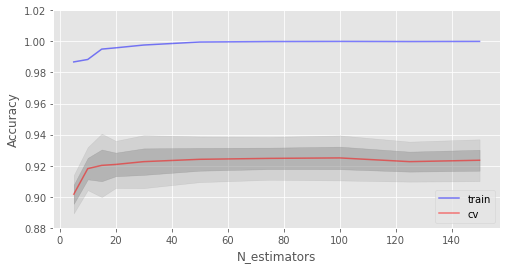

In [18]:
# Кривая обучения при изменении параметра
# Выбрал стиль графика
plt.style.use('ggplot')

# Создаю график и указываю размер отображения
fig, ax = plt.subplots(figsize=(8, 4))
# plot(Список параметров по оси Х, Средняя оценка для каждого параметра по оси y, Толщина кривой, Название кривой )
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')

# Отразим разброс оценок для каждого параметра
# fill_between - заполнение области между двумя горизонтальными кривыми
# Высчитываю стандартное отклонение и устанавливаю минимальные и максимальные границы по оси y для каждого параметра
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
# Диапазон значений y на графике
ax.set_ylim([0.88,1.02])

ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

На тестовой кривой достигается практически прямая. На тренировочной выборке достиг 100% - обозначает переобученность модели.

<b>Зафиксирую количество деревьев на 100 (n_estimators=100)</b>

Поиск максимальной глубины дерева

Best accuracy on CV is 92.50% with 26 max_depth


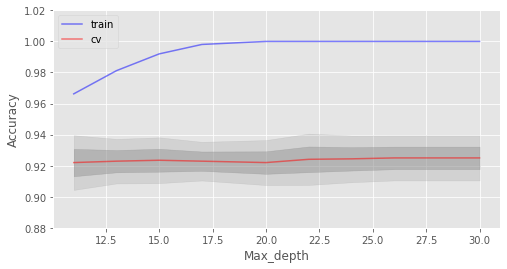

In [21]:
# Создаю списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [11, 13, 15, 17, 20, 22, 24, 26, 28, 30]

# Обучаю на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

<b>От х=17 модель переобучается. Результат не повысился</b>

Поиск min_samples_leaf (Минимальное число объектов в листе)

In [23]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 92.50% with 1 min_samples_leaf


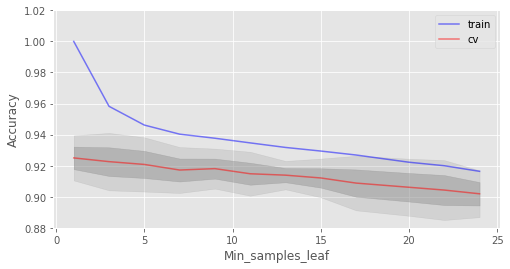

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

<b>Результат не улучшился</b>

Поиск max_features (Число признаков для разбиения)

Best accuracy on CV is 92.50% with 4 max_features


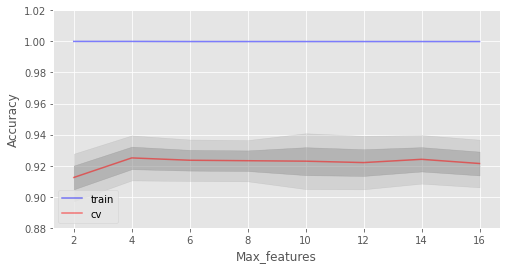

In [25]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

<b>Лучший результат достигается при х=4</b>

In [26]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [2, 4, 6, 8], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [10,15,20,24]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              

In [27]:
gcv.best_estimator_, gcv.best_score_

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=10, max_features=6,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                        warm_start=False),
 0.9261972617294957)

<b>Лучшая точность - 92.61%</b>
<p>При параметрах: max_features=6, min_samples_leaf=1, max_depth=10</p>